In [23]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import time
from torchvision import transforms
from torch.autograd import Variable
from torch import optim # GD를 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가시적으로 표현해 주는데, 특히 모델의 학습 경과를 확인하고 싶을 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)), # 원본 이미지를 임의의 스케일 범위의 크기만큼으로 자르고, 설정한 resize 크기로 조정
                transforms.RandomHorizontalFlip(), # 기본값이 0.5의 확률로 이미지들을 수평 반전 기킴.
                transforms.RandomRotation(90),
                transforms.ToTensor(), # torchvision의 PIL 라이브러리를 이용하여 이미지를 읽을 때 (H, W, C), [0, 255]로 읽어오는데, ToTensor()로 (C, H, W), [0.0, 1.0]으로 변환
                transforms.Normalize(mean, std) # ImageNet 데이터의 각 채널별 평균과 표준편차에 맞는 정규화 진행.  
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
                
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [5]:
cat_directory = '../input/cat-and-dog/training_set/training_set/cats'
dog_directory = '../input/cat-and-dog/training_set/training_set/dogs'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

test_cat_directory = '../input/cat-and-dog/test_set/test_set/cats'
test_dog_directory = '../input/cat-and-dog/test_set/test_set/dogs'

test_cat_images_filepaths = sorted([os.path.join(test_cat_directory, f) for f in os.listdir(test_cat_directory)])
test_dog_images_filepaths = sorted([os.path.join(test_dog_directory, f) for f in os.listdir(test_dog_directory)])

test_images_filepaths = [*test_cat_images_filepaths, *test_dog_images_filepaths]
test_correct_images_filepaths = [i for i in test_images_filepaths if cv2.imread(i) is not None]



random.seed(2022)
random.shuffle(correct_images_filepaths)
random.shuffle(test_correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:6000] 
val_images_filepaths = correct_images_filepaths[6000:]
test_images_filepaths = test_correct_images_filepaths    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

6000 2005 2023


In [6]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform = None, phase = 'train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-1].split('.')[0] # 이러면 label에 cat 혹은 dog 값이 들어간다.
        if label == 'dog':
            label = 1
        elif label == 'cat': 
            label = 0
        
        return img_transformed, label 

In [7]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [10]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')


index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
1


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0])


In [14]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2),
            nn.ReLU(inplace = True), # inplace: 결과값을 새로운 변수에 저장하는 것이 아닌, 기존 데이터를 대체하는 것.
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(64, 192, kernel_size = 5, stride = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) # 풀링 작업이 끝날 때 필요한 출력 크기를 정의한다. 
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
        
        
        
        
        

In [15]:
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inp

In [16]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [17]:
!pip install torchsummary

In [20]:
from torchsummary import summary
summary(model, input_size = (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 14, 14]         307,392
              ReLU-5          [-1, 192, 14, 14]               0
         MaxPool2d-6            [-1, 192, 6, 6]               0
            Conv2d-7            [-1, 384, 6, 6]         663,936
              ReLU-8            [-1, 384, 6, 6]               0
            Conv2d-9            [-1, 256, 6, 6]         884,992
             ReLU-10            [-1, 256, 6, 6]               0
           Conv2d-11            [-1, 256, 6, 6]         590,080
             ReLU-12            [-1, 256, 6, 6]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-14            [-1, 25

In [21]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    return model 
                    

In [24]:
num_epoch = 30
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/30
--------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5040


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.4973
Epoch 2/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5237


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6921 Acc: 0.6020
Epoch 3/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.5402


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6914 Acc: 0.5746
Epoch 4/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6919 Acc: 0.5440


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6903 Acc: 0.5601
Epoch 5/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6909 Acc: 0.5383


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6887 Acc: 0.5955
Epoch 6/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6895 Acc: 0.5615


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6856 Acc: 0.5426
Epoch 7/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6868 Acc: 0.5832


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6812 Acc: 0.5332
Epoch 8/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6825 Acc: 0.5743


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6752 Acc: 0.6214
Epoch 9/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6756 Acc: 0.5965


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6631 Acc: 0.6105
Epoch 10/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6694 Acc: 0.5975


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6636 Acc: 0.5945
Epoch 11/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6618 Acc: 0.6102


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6441 Acc: 0.6429
Epoch 12/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6510 Acc: 0.6268


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6298 Acc: 0.6549
Epoch 13/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6482 Acc: 0.6208


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6218 Acc: 0.6703
Epoch 14/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6367 Acc: 0.6448


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6085 Acc: 0.6883
Epoch 15/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6314 Acc: 0.6495


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5999 Acc: 0.6873
Epoch 16/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6241 Acc: 0.6550


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5867 Acc: 0.6963
Epoch 17/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6143 Acc: 0.6697


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5779 Acc: 0.7012
Epoch 18/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6013 Acc: 0.6827


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5520 Acc: 0.7332
Epoch 19/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5982 Acc: 0.6778


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5570 Acc: 0.7192
Epoch 20/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5928 Acc: 0.6823


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5688 Acc: 0.7077
Epoch 21/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5761 Acc: 0.7005


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5285 Acc: 0.7397
Epoch 22/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5702 Acc: 0.7078


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5276 Acc: 0.7491
Epoch 23/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5763 Acc: 0.6955


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5207 Acc: 0.7566
Epoch 24/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5630 Acc: 0.7060


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.4891 Acc: 0.7771
Epoch 25/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5502 Acc: 0.7195


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5176 Acc: 0.7317
Epoch 26/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5517 Acc: 0.7223


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6157 Acc: 0.6534
Epoch 27/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5569 Acc: 0.7140


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5066 Acc: 0.7701
Epoch 28/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5405 Acc: 0.7282


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5135 Acc: 0.7456
Epoch 29/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5257 Acc: 0.7387


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.4768 Acc: 0.7781
Epoch 30/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5280 Acc: 0.7438


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5303 Acc: 0.7117
Training complete in 29m 3s
Best val Acc: 0.7781


In [27]:
import pandas as pd
 
id_list = []
pred_list = []
_id = 0

with torch.no_grad(): # 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음을 나타내는 것으로, 훈련 데이터셋의 모델 학습과 가장 큰 차이점입니다. 
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase = 'val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim = 1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
print(len(id_list))
        
#res.sort_values(by = 'id', inplace = True)
#res.reset_index(drop = True, inplace = True)
        
res.to_csv('./LeNet', index = False )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2023 [00:00<?, ?it/s]

2023


In [28]:
class_ = classes = {0: 'cat', 1: 'dog'}
def display_image_grid(images_filepaths, predicted_labels = (), cols = 5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5: # dog
            label = 1
        else: # cat
            label = 0 
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

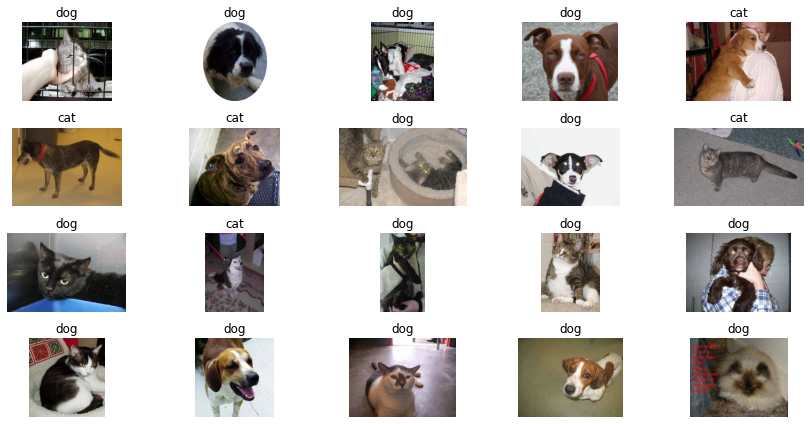

In [30]:
display_image_grid(test_images_filepaths[-20 : ])

In [2]:
t = torch.tensor([[[1, 2],
                    [3, 4]],
                   [[5, 6],
                 [7, 8]]])

In [4]:
print(t.size())

torch.Size([2, 2, 2])


In [6]:
t2 = torch.flatten(t, 1)
print(t2.size())

torch.Size([2, 4])
